In [1]:
from sleep_analysis.datasets.d04_main_dataset import D04MainStudy
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.signal import find_peaks


In [2]:
from empkins_io.sync import SyncedDataset

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [3]:
from biopsykit.signals.ecg import EcgProcessor
import neurokit2 as nk

In [4]:
from hrvanalysis import (
    get_csi_cvi_features,
    get_frequency_domain_features,
    get_geometrical_features,
    get_poincare_plot_features,
    get_time_domain_features,
)

In [5]:
from empkins_micro.emrad.radar import get_rpeaks, get_peak_probabilities

In [6]:
from fau_colors import cmaps, register_fausans_font

In [7]:
%matplotlib widget

In [8]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [9]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [10]:
from biopsykit.utils.array_handling import sliding_window

In [11]:
### General Settings
id = 4

# General Radar Settings
fs_radar = 1953.125

In [12]:
dataset = D04MainStudy(exclusion_criteria=["EEG"])

In [13]:
dataset

,subj_id
0,02
1,03
2,04
3,05
4,06
5,07
6,09
7,10
8,11
9,12


In [14]:
r_peak_df = pd.read_csv("r_peaks02.csv", index_col = 0, parse_dates=True)

In [15]:
r_peak_df.index.floor("30s").drop_duplicates().shape

(1089,)

In [16]:
r_peak_df = r_peak_df.dropna()[["R_Peak_Idx", "RR_Interval"]]

In [17]:
r_peak_df.index = pd.to_datetime(r_peak_df.index)

def overlapping_windows(df, window_seconds, overlap_seconds=30):
    # Calculate overlap
    overlap_seconds = window_seconds - 30
    window_size = pd.Timedelta(seconds=window_seconds)
    step_size = pd.Timedelta(seconds=(window_seconds - overlap_seconds))
    
    start_time = df.index.min()
    end_time = df.index.max()
    
    windows_dict = {}
    
    # Generate windows with overlap
    while start_time + window_size <= end_time:
        # Floor the start_time to the nearest 30-second mark
        floored_start_time = start_time.floor('30S')
        
        # Only proceed if the key (floored_start_time) doesn't exist in the dictionary
        if floored_start_time not in windows_dict:
            window = df.loc[start_time:start_time + window_size]
            if not window.empty:
                # Store the window in the dictionary with the floored_start_time as the key
                windows_dict[floored_start_time] = window
        
        # Move to the next window based on the step size
        start_time += step_size
    
    return windows_dict

# Example usage:
# Assuming df is your dataframe with a datetime index
windows = overlapping_windows(r_peak_df, window_seconds=150)

# Define window sizes (150, 210, and 270 seconds)
window_sizes = [150, 210, 270]

# Apply the function for each window size
windows_150s = overlapping_windows(r_peak_df, 150)
windows_210s = overlapping_windows(r_peak_df, 210)
windows_270s = overlapping_windows(r_peak_df, 270)

In [18]:
movement_features = pd.read_csv("movement_features_02.csv", index_col=0, parse_dates=True)
index = movement_features.index
index

DatetimeIndex(['2023-03-29 23:03:30+02:00', '2023-03-29 23:04:00+02:00',
               '2023-03-29 23:04:30+02:00', '2023-03-29 23:05:00+02:00',
               '2023-03-29 23:05:30+02:00', '2023-03-29 23:06:00+02:00',
               '2023-03-29 23:06:30+02:00', '2023-03-29 23:07:00+02:00',
               '2023-03-29 23:07:30+02:00', '2023-03-29 23:08:00+02:00',
               ...
               '2023-03-30 08:36:00+02:00', '2023-03-30 08:36:30+02:00',
               '2023-03-30 08:37:00+02:00', '2023-03-30 08:37:30+02:00',
               '2023-03-30 08:38:00+02:00', '2023-03-30 08:38:30+02:00',
               '2023-03-30 08:39:00+02:00', '2023-03-30 08:39:30+02:00',
               '2023-03-30 08:40:00+02:00', '2023-03-30 08:40:30+02:00'],
              dtype='datetime64[ns, pytz.FixedOffset(120)]', name='date (Europe/Berlin)', length=1155, freq=None)

In [19]:
epochs = len(index)  # Number of epochs

columns = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'sd1', 'sd2', 'ratio_sd2_sd1', 'csi', 'cvi',
       'Modified_csi', 'triangular_index', 'tinn']

# Initialize the DataFrame with zeros
feature_data = np.empty((epochs, len(columns)))
feature_data.fill(np.nan)

df_features = pd.DataFrame(feature_data, columns=columns, index=index)

df_features

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,total_power,vlf,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,triangular_index,tinn
date (Europe/Berlin),,,,,,,,,,,,,,,,,,,,,
2023-03-29 23:03:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29 23:04:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29 23:04:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29 23:05:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29 23:05:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 08:38:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 08:39:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 08:39:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
keys = windows.keys()

In [21]:
for key in keys:
    #display(windows[key])

    RR_values = windows[key]["RR_Interval"].values * 1000
    all_hr_features = {}
    try: 
        all_hr_features.update(get_time_domain_features(RR_values))
        all_hr_features.update(get_frequency_domain_features(RR_values))
        all_hr_features.update(get_poincare_plot_features(RR_values))
        all_hr_features.update(get_csi_cvi_features(RR_values))
        all_hr_features.update(get_geometrical_features(RR_values))

        all_hr_features = pd.DataFrame(all_hr_features, index = [key])
        #display(all_hr_features.columns)
        df_features.loc[key] = all_hr_features.loc[key]
    except:
        continue
    

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 76, using nperseg = 76
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 23, using nperseg = 23
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 15, using nperseg = 15
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 15, using n

In [22]:
df_features[200:250]

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,total_power,vlf,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,triangular_index,tinn
date (Europe/Berlin),,,,,,,,,,,,,,,,,,,,,
2023-03-30 00:43:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:44:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:44:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:45:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:45:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:46:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:46:30+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:47:00+02:00,716.800000,23.894552,0.000000,0.0,0.000000,1.0,100.000000,33.792000,716.800,33.792,...,13.044295,1.165247,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN
2023-03-30 00:47:30+02:00,862.720000,253.304982,193.536000,1.0,50.000000,2.0,100.000000,298.553518,733.696,454.656,...,2340.020240,3.792765,193.536000,301.447582,1.557579,1.557579,5.970094,1878.113524,3.000000,NaN


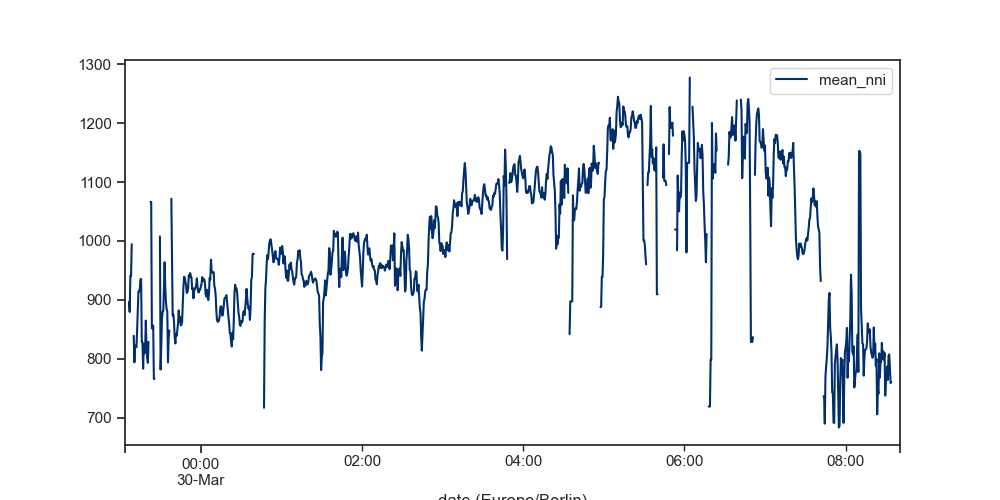

In [23]:
df_features[["mean_nni"]].plot()
plt.show()